Nicholas Kurtansky, Veronica Rotemberg, Maura Gillis, Kivanc Kose, Walter Reade, Ashley Chow. (2024). ISIC 2024 - Skin Cancer Detection with 3D-TBP. Kaggle. https://kaggle.com/competitions/isic-2024-challenge

# ISIC 2024 - Skin Cancer Detection with 3D-TBP



Based on: 

https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only

In [1]:
import pandas as pd
import glob

import os
import os.path as path
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.optim import lr_scheduler
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
# import torchvision
# from torcheval.metrics.functional import binary_auroc

# Tensorflow Imports
import tensorflow as tf
import keras

# Utils
# import joblib
# from tqdm import tqdm
# from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# For Image Models
# import timm

# Albumentations for augmentations
import albumentations as A
# from albumentations.pytorch import ToTensorV2

# For colored terminal text
# from colorama import Fore, Back, Style
# b_ = Fore.BLUE
# sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

2024-08-28 23:35:57.318710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 23:35:57.703491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 23:35:57.704412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 23:35:57.930146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 23:35:59.392395: W tensorflow/compiler/tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def set_seeds(seed=42):

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
  
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
set_seeds()

In [6]:
# https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only#Training-Function

ROOT_DIR = path.normpath(os.curdir + "/data/")
TRAIN_DIR = f'{ROOT_DIR}/train-image/image/'

def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
print(TRAIN_DIR)
print("train_images>", len(train_images))

data/train-image/image/
train_images> 401059


In [8]:
train_images[:5]

['data/train-image/image/ISIC_0015670.jpg',
 'data/train-image/image/ISIC_0015845.jpg',
 'data/train-image/image/ISIC_0015864.jpg',
 'data/train-image/image/ISIC_0015902.jpg',
 'data/train-image/image/ISIC_0024200.jpg']

data/train-image/image//ISIC_0015864.jpg


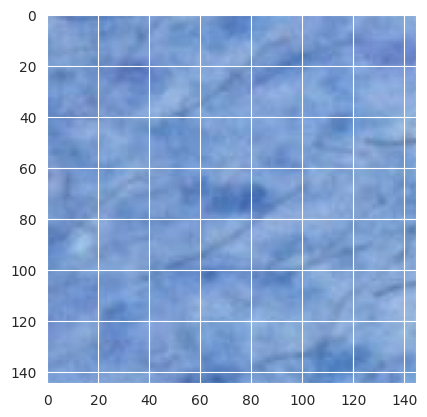

In [9]:
print(get_train_file_path("ISIC_0015864"))
img = cv2.imread(get_train_file_path("ISIC_0015864"))

plt.imshow(img)

In [10]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("        df.shape, # of positive cases, # of patients")
print("original", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

# Potential imbalanced dataset
# df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
# print("filtered", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
# df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df.head()

        df.shape, # of positive cases, # of patients
original (401059, 55) 393 (1042,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,data/train-image/image//ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,data/train-image/image//ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,data/train-image/image//ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,data/train-image/image//ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,data/train-image/image//ISIC_0024200.jpg


In [11]:
# Data exploration

print("Number of unique patients: ", df["patient_id"].nunique())

Number of unique patients:  1042


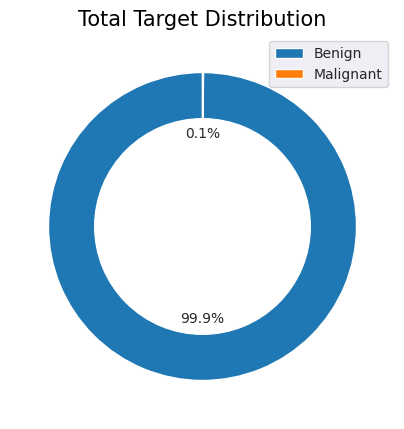

(400666, 55) (393, 55)


In [12]:
name = ['Benign', 'Malignant']

plt.figure(figsize = (5, 5))
plt.pie(df.target.value_counts(normalize = True), autopct = '%1.1f%%', startangle = 90, wedgeprops = dict(width = 0.3), 
        labeldistance = 1.2, radius = 1)
plt.title(f'Total Target Distribution', color = 'black', fontsize = 15)
plt.legend(name,)

plt.show()

print(df_negative.shape, df_positive.shape)

In [13]:

missing_values_count = df.isnull().sum()
print(sorted(missing_values_count, reverse=True))

[401058, 401006, 400996, 400508, 399994, 399991, 379001, 11517, 5756, 2798, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "",
    "checkpoint_path" : "/ISIC2024_SkinCancerDetection/saved_models",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    # "device": nn.device("cuda:0" if nn.cuda. else "cpu"),
    "device" : "GPU" if tf.config.list_physical_devices('GPU') else "CPU",
}

print(f"Using device: {CONFIG['device']}")

Using device: GPU


2024-08-28 23:37:41.907265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 23:37:42.464735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 23:37:42.464827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.)
}


In [ ]:
def aug_fn(image, img_size, train):
    data = {"image":image}
    aug_data = data_transforms(**data["train" if train else "valid"])
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [ ]:
def process_data(image, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [ ]:

# Hyperparameters
batch_size = 128
activation_func = 'gelu'
# activation_func = 'relu'
# activation_func = 'mish'

num_epochs = 950
learning_rate = 3.5e-4
criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

In [18]:
import h5py

# Loading images

x_train = []
y_train = []
with h5py.File('./data/train-image.hdf5', 'r') as f:
       keys = list(f.keys())
       for key in keys:
           data = f[key]
           if data.shape == () and data.dtype.kind == 'S':
            try:
                # Try decoding with latin-1
                x_train.append(data[()].decode('latin-1'))
            except UnicodeDecodeError:
                print(f"Failed to decode {key}, appending raw data")
                x_train.append(data[()]) 
               
           
           # x_train.append(f[key][:]) 
           y_train.append(key)
              
print(x_train.shape, y_train.shape)

KeyboardInterrupt: 

In [19]:
# https://www.kaggle.com/code/awsaf49/isic2024-kerascv-starter

import h5py

training_validation_hdf5 = h5py.File(f"{ROOT_DIR}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{ROOT_DIR}/test-image.hdf5", 'r')

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


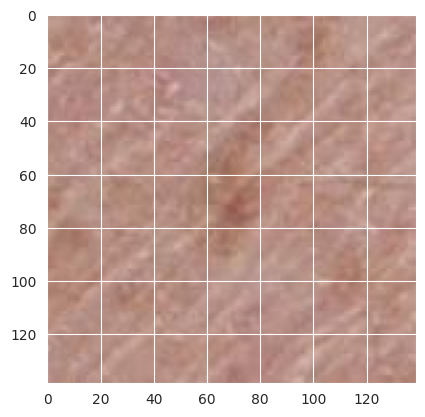

In [23]:
isic_id = df.isic_id.iloc[0]

# Image as Byte String
byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to a numpy array
nparr = np.frombuffer(byte_string, np.uint8)

image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image);

In [24]:
training_ids = df.isic_id.values

images = [None]*len(training_ids)
for i, isic_id in enumerate(training_ids):
    images[i] = training_validation_hdf5[isic_id][()]

print(f"Loaded {len(images)} images")

Loaded 401059 images


In [ ]:
def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image



In [ ]:
decoded_images = [cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)[...,::-1] for img in images]

ds = tf.data.Dataset.from_tensor_slices(slices)
ds = ds.cache() if cache else ds
ds = ds.map(decode_fn, num_parallel_calls=AUTO)


decoded_images[0].shape    

In [32]:
def split_dataset(dataset, test_ratio=0.15):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds, valid_ds = split_dataset(df)

print("{} examples in training, {} examples in testing.".format(
    len(train_ds), len(valid_ds)))

train_ds.head()

341011 examples in training, 60048 examples in testing.


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../ISIC2024_SkinCancerDetection/data/train-ima...
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../ISIC2024_SkinCancerDetection/data/train-ima...
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../ISIC2024_SkinCancerDetection/data/train-ima...
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../ISIC2024_SkinCancerDetection/data/train-ima...
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../ISIC2024_SkinCancerDetection/data/train-ima...


In [33]:

x_train = [cv2.imread(img) for img in train_ds['file_path'].values]
x_train = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in x_train]
# x_train = [img.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE) for img in x_train]

y_train = train_ds['target'].values
x_valid = [cv2.imread(img) for img in valid_ds['file_path'].values]
y_valid = valid_ds['target'].values

print(x_train.shape, y_train.shape)
x_train[0].shape

KeyboardInterrupt: 

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train, dtype=tf.float32),
                                                    tf.convert_to_tensor(y_train, dtype=tf.float32)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_test, dtype=tf.float32),
                                                  tf.convert_to_tensor(y_test, dtype=tf.float32)))

train_loader = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size, drop_remainder=True)
val_loader = val_dataset.shuffle(buffer_size=len(val_dataset)).batch(batch_size, drop_remainder=True)

In [ ]:

class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = tf.keras.layers.Dense(234, activation=activation_func)

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))

        self.hidden_layers = []
        for i in range(17):
            self.hidden_layers.append(tf.keras.layers.Dense(1024, activation=activation_func))
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())


        self.additional_layers = []
        for i in range(2):
            self.additional_layers.append(tf.keras.layers.Dense(512, activation=activation_func))
            self.additional_layers.append(tf.keras.layers.Dropout(0.2))

        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.input_layer(x)
        # for layer in self.feature_extractor:
        #     x = layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        for layer in self.additional_layers:
            x = layer(x)

        return self.output_layer(x)

model = Net()

In [ ]:

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_loader):
        with tf.GradientTape() as tape:
            outputs = model(batch_x, training=True)
            loss = criterion(batch_y, tf.squeeze(outputs))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_loss += loss.numpy()

    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    val_loss = 0
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x, training=False)
        loss = criterion(batch_y, tf.squeeze(outputs))
        val_loss += loss.numpy()

    val_losses.append(val_loss / len(val_loader))

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss / len(val_loader):.4f}"
    )

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Set model to inference mode (not strictly necessary in TensorFlow as it handles this automatically)
# Making predictions on training and testing data
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

y_train_pred = model(x_train_tensor, training=False).numpy()
y_test_pred = model(x_test_tensor, training=False).numpy()

In [ ]:

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f'Train R-squared: {train_r2 * 100:.2f}%')
    print(f'Test R-squared: {test_r2 * 100:.2f}%')
    print(f'Test Mean Squared Error (MSE): {test_mse:.2f}')
    print(f'Test Root Mean Squared Error (RMSE): {test_rmse:.2f}')
    print(f'Test Mean Absolute Error (MAE): {test_mae:.2f}')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual', marker='o', linestyle='None')
    plt.plot(y_test_pred, label='Predicted', marker='x', linestyle='None')
    plt.legend()
    plt.xlabel('Sample index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

    print(model.summary())
    print(model.get_config())
    print(optimizer.get_config())
    print(model.loss)

In [ ]:
# Transfer Learning [freeze all layers of feature extractor]: Functional API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(CONFIG["img_size"], CONFIG["img_size"], 3), weights="imagenet")
base_model.trainable = False

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(1, activation='softmax')

    @tf.function
    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.layer_3(x)


model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_data, epochs=2)